In [3]:
import warnings

warnings.filterwarnings("ignore")

In [4]:
import pandas as pd
import numpy as np
import h5py
from matplotlib import pyplot as plt
from matplotlib.path import Path
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
from sklearn.kernel_ridge import KernelRidge
import scipy
from scipy.constants import physical_constants

In [5]:
def h5group_to_dict(grp):
    dct = {}
    for key, val in grp.items():
        if isinstance(val, h5py.Dataset):
            dct[key] = val[()]
        else:
            dct[key] = h5group_to_dict(val)
    return dct

In [6]:
tab_xc = pd.read_csv("functionals.csv", encoding="UTF-8", index_col=[0])

In [7]:
tab_rdf = pd.concat([
    pd.read_csv("Table-RDF-dh.csv", index_col=[0], header=[0, 1]),
    pd.read_csv("Table-RDF-low.csv", index_col=[0], header=[0, 1])]
).loc[tab_xc.index]

In [8]:
l = sorted(tab_rdf.index)

In [9]:
tab_rdf["RHO"].T.max()

functional
Slater      4.864004
SVWN        3.725131
SVWN1RPA    3.631283
VWN1RPA     3.650341
VWN5        3.539821
              ...   
r++SCAN     2.055890
R2SCAN0     2.058658
R2SCAN50    2.020525
R4SCAN      2.076695
R4SCAN0     2.042890
Length: 173, dtype: float64

In [10]:
mask_lda = tab_xc["type"] == "LDA"
mask_gga = tab_xc["type"] == "GGA"
mask_mgga = tab_xc["type"] == "mGGA"

In [11]:
mask_hyb_ex = ~pd.isna(tab_xc["hybrid ex"])
mask_hyb_corr = ~pd.isna(tab_xc["hybrid corr"])

## RHO

In [12]:
plt_x = tab_xc["year"]
plt_y = tab_rdf["RHO"].T.max()
plt_year_x = list(range(1974, 2023))

plt_year_y = []
for year in range(1974, 2023):
    mask_year = (tab_xc["year"] > year - 5) & (tab_xc["year"] < year + 5)
    plt_year_y.append(plt_y[mask_year].mean())
plt_year_y_another = []
for year in range(len(plt_year_y)):
    plt_year_y_another.append(np.array(plt_year_y[max(0, year - 5):year + 5]).mean())
plt_year_y_another, plt_year_y = plt_year_y, plt_year_y_another

plt_year_y_low = []
for year in range(1974, 2023):
    mask_year = (tab_xc["year"] > year - 5) & (tab_xc["year"] < year + 5) & ~mask_hyb_corr
    plt_year_y_low.append(plt_y[mask_year].mean())
plt_year_y_another = []
for year in range(len(plt_year_y_low)):
    plt_year_y_another.append(np.array(plt_year_y_low[max(0, year - 5):year + 5]).mean())
plt_year_y_another, plt_year_y_low = plt_year_y_low, plt_year_y_another

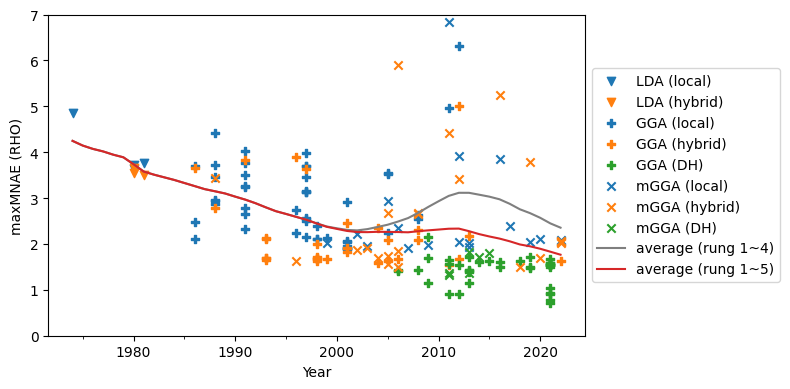

In [13]:
fig, ax = plt.subplots(figsize=(8, 4))

# plt.scatter(plt_x, plt_y, marker=Path([(0, 0), (0, 1), (1, 1), (1, 0)]), s=1000)
ax.scatter(plt_x[mask_lda  & ~mask_hyb_ex], plt_y[mask_lda & ~mask_hyb_ex], marker="v", color="C0", label="LDA (local)" )
ax.scatter(plt_x[mask_lda  &  mask_hyb_ex], plt_y[mask_lda &  mask_hyb_ex], marker="v", color="C1", label="LDA (hybrid)")
ax.scatter(plt_x[mask_gga  & ~mask_hyb_ex & ~mask_hyb_corr], plt_y[mask_gga  & ~mask_hyb_ex & ~mask_hyb_corr], marker="P", color="C0", label="GGA (local)" )
ax.scatter(plt_x[mask_gga  &  mask_hyb_ex & ~mask_hyb_corr], plt_y[mask_gga  &  mask_hyb_ex & ~mask_hyb_corr], marker="P", color="C1", label="GGA (hybrid)")
ax.scatter(plt_x[mask_gga  &  mask_hyb_ex &  mask_hyb_corr], plt_y[mask_gga  &  mask_hyb_ex &  mask_hyb_corr], marker="P", color="C2", label="GGA (DH)"    )
ax.scatter(plt_x[mask_mgga & ~mask_hyb_ex & ~mask_hyb_corr], plt_y[mask_mgga & ~mask_hyb_ex & ~mask_hyb_corr], marker="x", color="C0", label="mGGA (local)" )
ax.scatter(plt_x[mask_mgga &  mask_hyb_ex & ~mask_hyb_corr], plt_y[mask_mgga &  mask_hyb_ex & ~mask_hyb_corr], marker="x", color="C1", label="mGGA (hybrid)")
ax.scatter(plt_x[mask_mgga &  mask_hyb_ex &  mask_hyb_corr], plt_y[mask_mgga &  mask_hyb_ex &  mask_hyb_corr], marker="x", color="C2", label="mGGA (DH)"    )

ax.plot(plt_year_x, plt_year_y_low, color="C7", label="average (rung 1~4)")
ax.plot(plt_year_x, plt_year_y, color="C3", label="average (rung 1~5)")

ax.set_xlabel("Year")
ax.set_ylabel("maxMNAE (RHO)")
ax.set_ylim(0, 7)
ax.set_xticks(range(1975, 2025, 5), minor=True)
ax.set_xticks(range(1980, 2025, 10), minor=False)

ax.legend(bbox_to_anchor=(1.0, 0.5), loc="center left")
fig.tight_layout()

## maxMNAE

In [40]:
def plot_time_series(ax, typ):
    plt_x = tab_xc["year"]
    plt_y = tab_rdf[typ].T.max()
    plt_year_x = list(range(1974, 2023))

    plt_year_y = []
    for year in range(1974, 2023):
        mask_year = (tab_xc["year"] > year - 5) & (tab_xc["year"] < year + 5)
        plt_year_y.append(plt_y[mask_year].mean())
    plt_year_y_another = []
    for year in range(len(plt_year_y)):
        plt_year_y_another.append(np.array(plt_year_y[max(0, year - 5):year + 5]).mean())
    plt_year_y_another, plt_year_y = plt_year_y, plt_year_y_another

    plt_year_y_low = []
    for year in range(1974, 2023):
        mask_year = (tab_xc["year"] > year - 5) & (tab_xc["year"] < year + 5) & ~mask_hyb_corr
        plt_year_y_low.append(plt_y[mask_year].mean())
    plt_year_y_another = []
    for year in range(len(plt_year_y_low)):
        plt_year_y_another.append(np.array(plt_year_y_low[max(0, year - 5):year + 5]).mean())
    plt_year_y_another, plt_year_y_low = plt_year_y_low, plt_year_y_another

    # plt.scatter(plt_x, plt_y, marker=Path([(0, 0), (0, 1), (1, 1), (1, 0)]), s=1000)
    ax.scatter(plt_x[mask_lda  & ~mask_hyb_ex], plt_y[mask_lda & ~mask_hyb_ex], marker="v", color="C0", label="LDA (local)" )
    ax.scatter(plt_x[mask_lda  &  mask_hyb_ex], plt_y[mask_lda &  mask_hyb_ex], marker="v", color="C1", label="LDA (hybrid)")
    ax.scatter(plt_x[mask_gga  & ~mask_hyb_ex & ~mask_hyb_corr], plt_y[mask_gga  & ~mask_hyb_ex & ~mask_hyb_corr], marker="x", color="C0", label="GGA (local)" )
    ax.scatter(plt_x[mask_gga  &  mask_hyb_ex & ~mask_hyb_corr], plt_y[mask_gga  &  mask_hyb_ex & ~mask_hyb_corr], marker="x", color="C1", label="GGA (hybrid)")
    ax.scatter(plt_x[mask_gga  &  mask_hyb_ex &  mask_hyb_corr], plt_y[mask_gga  &  mask_hyb_ex &  mask_hyb_corr], marker="x", color="C2", label="GGA (DH)"    )
    ax.scatter(plt_x[mask_mgga & ~mask_hyb_ex & ~mask_hyb_corr], plt_y[mask_mgga & ~mask_hyb_ex & ~mask_hyb_corr], marker="+", color="C0", label="mGGA (local)" )
    ax.scatter(plt_x[mask_mgga &  mask_hyb_ex & ~mask_hyb_corr], plt_y[mask_mgga &  mask_hyb_ex & ~mask_hyb_corr], marker="+", color="C1", label="mGGA (hybrid)")
    ax.scatter(plt_x[mask_mgga &  mask_hyb_ex &  mask_hyb_corr], plt_y[mask_mgga &  mask_hyb_ex &  mask_hyb_corr], marker="+", color="C2", label="mGGA (DH)"    )

    ax.plot(plt_year_x, plt_year_y_low, color="C7", label="average (rung 1~4)")
    ax.plot(plt_year_x, plt_year_y, color="C3", label="average (rung 1~5)")

    ax.set_ylabel(f"maxMNAE ({typ})")
    ax.set_xticks(range(1975, 2025, 5), minor=True)
    ax.set_xticks(range(1980, 2025, 10), minor=False)

    return ax

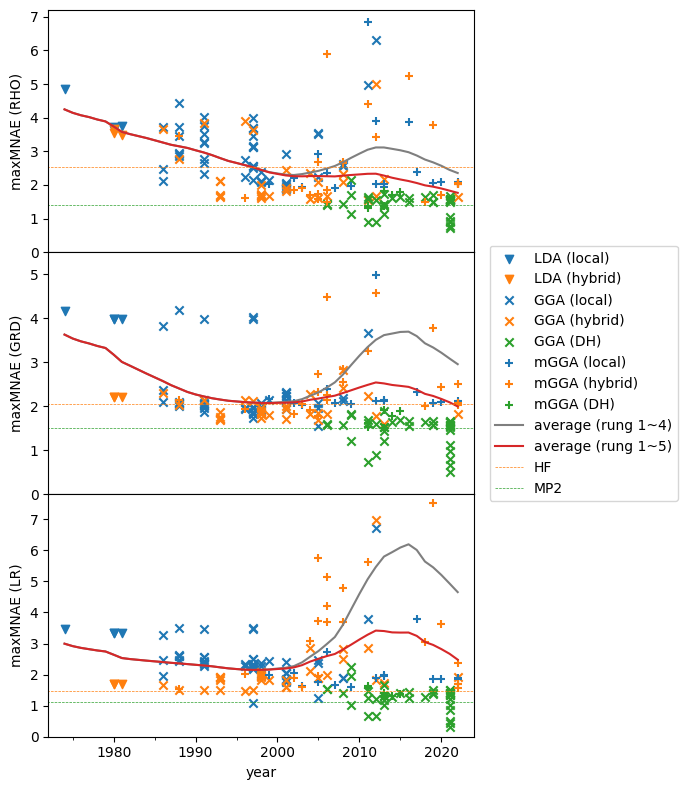

In [41]:
fig = plt.figure(figsize=(7, 8))
gs = fig.add_gridspec(3, 1, hspace=0, wspace=0)
axs = gs.subplots(sharex=True)

plot_time_series(axs[0], "RHO")
plot_time_series(axs[1], "GRD")
plot_time_series(axs[2], "LR")

axs[0].set_ylim(0, 7.2)
axs[1].set_ylim(0, 5.5)
axs[2].set_ylim(0, 7.8)
axs[0].set_xlim(1972, 2024)
axs[0].plot([0, 10000], [2.526159] * 2, color="C1", linewidth=0.5, linestyle="--")
axs[0].plot([0, 10000], [1.413852] * 2, color="C2", linewidth=0.5, linestyle="--")
axs[1].plot([0, 10000], [2.052249] * 2, color="C1", linewidth=0.5, linestyle="--", label="HF")
axs[1].plot([0, 10000], [1.511796] * 2, color="C2", linewidth=0.5, linestyle="--", label="MP2")
axs[2].plot([0, 10000], [1.460903] * 2, color="C1", linewidth=0.5, linestyle="--")
axs[2].plot([0, 10000], [1.114343] * 2, color="C2", linewidth=0.5, linestyle="--")
axs[2].set_xlabel("year")

axs[1].legend(bbox_to_anchor=(1.02, 0.5), loc="center left")

fig.tight_layout()
fig.savefig("../maxMNAE-against-year.pdf", transparent=True)

In [42]:
list(tab_rdf.index[(tab_rdf["RHO"].T.max() > 7.2)])

[]

In [43]:
list(tab_rdf.index[(tab_rdf["GRD"].T.max() > 5.5)])

['M11-L', 'N12', 'N12-SX', 'MN15', 'MN15-L']

In [44]:
list(tab_rdf.index[(tab_rdf["LR"].T.max() > 7.8)])

['M11-L', 'MN12-L', 'MN12-SX', 'MN15', 'MN15-L']

## meanMNAE

In [46]:
def plot_time_series(ax, typ):
    plt_x = tab_xc["year"]
    plt_y = tab_rdf[typ].T.mean()
    plt_year_x = list(range(1974, 2023))

    plt_year_y = []
    for year in range(1974, 2023):
        mask_year = (tab_xc["year"] > year - 5) & (tab_xc["year"] < year + 5)
        plt_year_y.append(plt_y[mask_year].mean())
    plt_year_y_another = []
    for year in range(len(plt_year_y)):
        plt_year_y_another.append(np.array(plt_year_y[max(0, year - 5):year + 5]).mean())
    plt_year_y_another, plt_year_y = plt_year_y, plt_year_y_another

    plt_year_y_low = []
    for year in range(1974, 2023):
        mask_year = (tab_xc["year"] > year - 5) & (tab_xc["year"] < year + 5) & ~mask_hyb_corr
        plt_year_y_low.append(plt_y[mask_year].mean())
    plt_year_y_another = []
    for year in range(len(plt_year_y_low)):
        plt_year_y_another.append(np.array(plt_year_y_low[max(0, year - 5):year + 5]).mean())
    plt_year_y_another, plt_year_y_low = plt_year_y_low, plt_year_y_another

    # plt.scatter(plt_x, plt_y, marker=Path([(0, 0), (0, 1), (1, 1), (1, 0)]), s=1000)
    ax.scatter(plt_x[mask_lda  & ~mask_hyb_ex], plt_y[mask_lda & ~mask_hyb_ex], marker="v", color="C0", label="LDA (local)" )
    ax.scatter(plt_x[mask_lda  &  mask_hyb_ex], plt_y[mask_lda &  mask_hyb_ex], marker="v", color="C1", label="LDA (hybrid)")
    ax.scatter(plt_x[mask_gga  & ~mask_hyb_ex & ~mask_hyb_corr], plt_y[mask_gga  & ~mask_hyb_ex & ~mask_hyb_corr], marker="x", color="C0", label="GGA (local)" )
    ax.scatter(plt_x[mask_gga  &  mask_hyb_ex & ~mask_hyb_corr], plt_y[mask_gga  &  mask_hyb_ex & ~mask_hyb_corr], marker="x", color="C1", label="GGA (hybrid)")
    ax.scatter(plt_x[mask_gga  &  mask_hyb_ex &  mask_hyb_corr], plt_y[mask_gga  &  mask_hyb_ex &  mask_hyb_corr], marker="x", color="C2", label="GGA (DH)"    )
    ax.scatter(plt_x[mask_mgga & ~mask_hyb_ex & ~mask_hyb_corr], plt_y[mask_mgga & ~mask_hyb_ex & ~mask_hyb_corr], marker="+", color="C0", label="mGGA (local)" )
    ax.scatter(plt_x[mask_mgga &  mask_hyb_ex & ~mask_hyb_corr], plt_y[mask_mgga &  mask_hyb_ex & ~mask_hyb_corr], marker="+", color="C1", label="mGGA (hybrid)")
    ax.scatter(plt_x[mask_mgga &  mask_hyb_ex &  mask_hyb_corr], plt_y[mask_mgga &  mask_hyb_ex &  mask_hyb_corr], marker="+", color="C2", label="mGGA (DH)"    )

    ax.plot(plt_year_x, plt_year_y_low, color="C7", label="average (rung 1~4)")
    ax.plot(plt_year_x, plt_year_y, color="C3", label="average (rung 1~5)")

    ax.set_ylabel(f"meanMNAE ({typ})")
    ax.set_xticks(range(1975, 2025, 5), minor=True)
    ax.set_xticks(range(1980, 2025, 10), minor=False)

    return ax

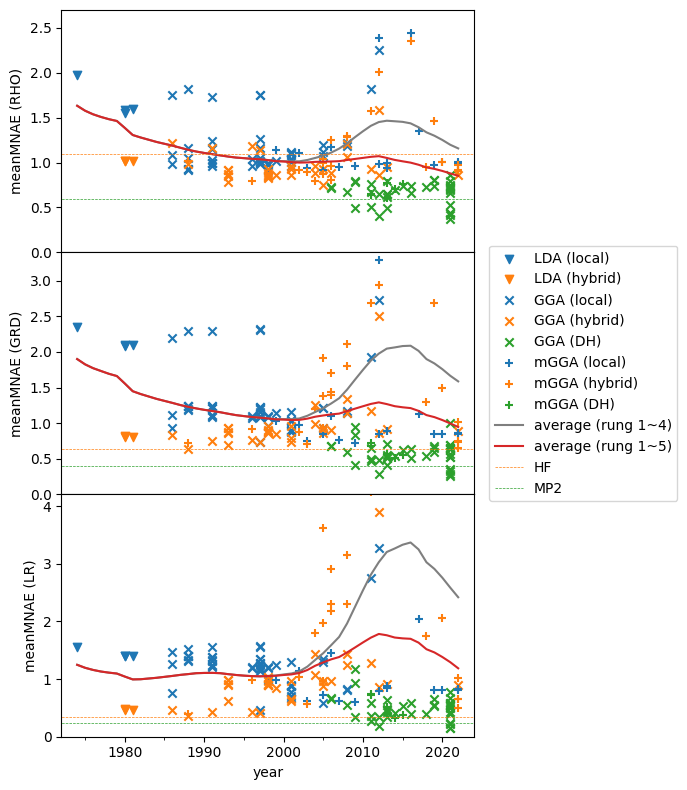

In [47]:
fig = plt.figure(figsize=(7, 8))
gs = fig.add_gridspec(3, 1, hspace=0, wspace=0)
axs = gs.subplots(sharex=True)

plot_time_series(axs[0], "RHO")
plot_time_series(axs[1], "GRD")
plot_time_series(axs[2], "LR")

axs[0].set_ylim(0, 2.7)
axs[1].set_ylim(0, 3.4)
axs[2].set_ylim(0, 4.2)
axs[0].set_xlim(1972, 2024)
axs[0].plot([0, 10000], [1.100308] * 2, color="C1", linewidth=0.5, linestyle="--")
axs[0].plot([0, 10000], [0.590162] * 2, color="C2", linewidth=0.5, linestyle="--")
axs[1].plot([0, 10000], [0.642692] * 2, color="C1", linewidth=0.5, linestyle="--", label="HF")
axs[1].plot([0, 10000], [0.406048] * 2, color="C2", linewidth=0.5, linestyle="--", label="MP2")
axs[2].plot([0, 10000], [0.344328] * 2, color="C1", linewidth=0.5, linestyle="--")
axs[2].plot([0, 10000], [0.232373] * 2, color="C2", linewidth=0.5, linestyle="--")
axs[2].set_xlabel("year")

axs[1].legend(bbox_to_anchor=(1.02, 0.5), loc="center left")

fig.tight_layout()
fig.savefig("../meanMNAE-against-year.pdf", transparent=True)

In [21]:
list(tab_rdf.index[(tab_rdf["RHO"].T.mean() > 2.7)])

['M11-L']

In [22]:
list(tab_rdf.index[(tab_rdf["GRD"].T.mean() > 3.4)])

['M11-L', 'MN15', 'MN15-L']

In [23]:
list(tab_rdf.index[(tab_rdf["LR"].T.mean() > 4.2)])

['M11', 'M11-L', 'MN12-L', 'MN12-SX', 'MN15', 'MN15-L', 'revM11']

## Energy Reference Values

In [24]:
ref_etot = pd.Series({
    "B": 63.069, "C": 112.336, "N": 175.259,
    "O": 251.814, "F": 341.988, "Ne": 445.771})

CCSD

In [25]:
with h5py.File("etot.h5", "r") as f:
    v = h5group_to_dict(f["CCSD"]["aug-cc-pwcv5z"])
    v = pd.Series(v)

In [26]:
err_etot = physical_constants["hartree-electron volt relationship"][0] * (
    v[["B+3", "C+4", "N+5", "O+6", "F+7", "Ne+8"]] - np.array(v[["B+1", "C+2", "N+3", "O+4", "F+5", "Ne+6"]])
) - np.array(ref_etot)
err_etot *= -1
err_etot

B+3     0.022757
C+4     0.022995
N+5     0.019120
O+6     0.013129
F+7     0.004082
Ne+8   -0.012345
dtype: float64

MP2

In [27]:
with h5py.File("etot-ri.h5", "r") as f:
    v = h5group_to_dict(f["MP2-ETB"]["aug-cc-pwcv5z"])
    v = pd.Series(v)

In [28]:
err_etot = physical_constants["hartree-electron volt relationship"][0] * (
    v[["B+3", "C+4", "N+5", "O+6", "F+7", "Ne+8"]] - np.array(v[["B+1", "C+2", "N+3", "O+4", "F+5", "Ne+6"]])
) - np.array(ref_etot)
err_etot *= -1
err_etot

B+3     0.601647
C+4     0.757199
N+5     0.907752
O+6     1.056091
F+7     1.201221
Ne+8    1.339057
dtype: float64

In [29]:
err_etot.abs().mean(), err_etot.abs().max(), (err_etot.abs()**2).mean()**0.5

(0.977161164698367, 1.3390571600781414, 1.0091809341479623)

HF

In [30]:
with h5py.File("etot-ri.h5", "r") as f:
    v = h5group_to_dict(f["HF-ETB"]["aug-cc-pwcv5z"])
    v = pd.Series(v)

In [31]:
err_etot = physical_constants["hartree-electron volt relationship"][0] * (
    v[["B+3", "C+4", "N+5", "O+6", "F+7", "Ne+8"]] - np.array(v[["B+1", "C+2", "N+3", "O+4", "F+5", "Ne+6"]])
) - np.array(ref_etot)
err_etot *= -1
err_etot

B+3     1.807302
C+4     2.204793
N+5     2.574307
O+6     2.927101
F+7     3.267797
Ne+8    3.594777
dtype: float64

In [32]:
err_etot.abs().mean(), err_etot.abs().max(), (err_etot.abs()**2).mean()**0.5

(2.729346050294114, 3.594776779871495, 2.7965259715230393)

## Energy

In [33]:
tab_etot = pd.concat([
    pd.read_csv("Table-etot-dh.csv", index_col=[0], header=[0]),
    pd.read_csv("Table-etot-low.csv", index_col=[0], header=[0])]
).loc[tab_xc.index]

ref_etot = pd.Series({
    "B": 63.069, "C": 112.336, "N": 175.259,
    "O": 251.814, "F": 341.988, "Ne": 445.771})

tab_etot = physical_constants["hartree-electron volt relationship"][0] * (
    + tab_etot[["B+3", "C+4", "N+5", "O+6", "F+7", "Ne+8"]]
    - np.array(tab_etot[["B+1", "C+2", "N+3", "O+4", "F+5", "Ne+6"]]))
tab_etot.columns = ref_etot.index
tab_etot = tab_etot - ref_etot

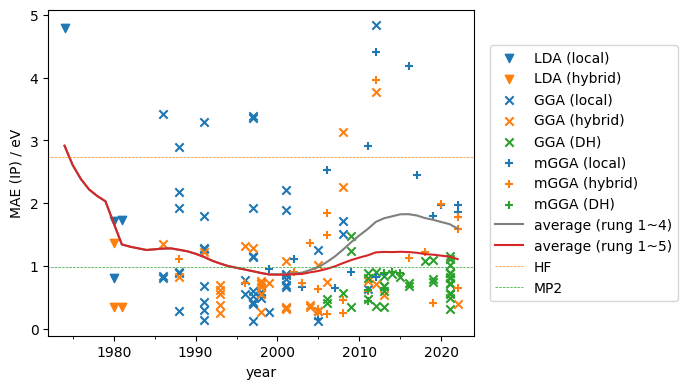

In [34]:
fig, ax = plt.subplots(figsize=(7, 4))

plt_x = tab_xc["year"]
plt_y = tab_etot.abs().T.mean()
plt_year_x = list(range(1974, 2023))

plt_year_y = []
for year in range(1974, 2023):
    mask_year = (tab_xc["year"] > year - 5) & (tab_xc["year"] < year + 5)
    plt_year_y.append(plt_y[mask_year].mean())
plt_year_y_another = []
for year in range(len(plt_year_y)):
    plt_year_y_another.append(np.array(plt_year_y[max(0, year - 5):year + 5]).mean())
plt_year_y_another, plt_year_y = plt_year_y, plt_year_y_another

plt_year_y_low = []
for year in range(1974, 2023):
    mask_year = (tab_xc["year"] > year - 5) & (tab_xc["year"] < year + 5) & ~mask_hyb_corr
    plt_year_y_low.append(plt_y[mask_year].mean())
plt_year_y_another = []
for year in range(len(plt_year_y_low)):
    plt_year_y_another.append(np.array(plt_year_y_low[max(0, year - 5):year + 5]).mean())
plt_year_y_another, plt_year_y_low = plt_year_y_low, plt_year_y_another

ax.scatter(plt_x[mask_lda  & ~mask_hyb_ex], plt_y[mask_lda & ~mask_hyb_ex], marker="v", color="C0", label="LDA (local)" )
ax.scatter(plt_x[mask_lda  &  mask_hyb_ex], plt_y[mask_lda &  mask_hyb_ex], marker="v", color="C1", label="LDA (hybrid)")
ax.scatter(plt_x[mask_gga  & ~mask_hyb_ex & ~mask_hyb_corr], plt_y[mask_gga  & ~mask_hyb_ex & ~mask_hyb_corr], marker="x", color="C0", label="GGA (local)" )
ax.scatter(plt_x[mask_gga  &  mask_hyb_ex & ~mask_hyb_corr], plt_y[mask_gga  &  mask_hyb_ex & ~mask_hyb_corr], marker="x", color="C1", label="GGA (hybrid)")
ax.scatter(plt_x[mask_gga  &  mask_hyb_ex &  mask_hyb_corr], plt_y[mask_gga  &  mask_hyb_ex &  mask_hyb_corr], marker="x", color="C2", label="GGA (DH)"    )
ax.scatter(plt_x[mask_mgga & ~mask_hyb_ex & ~mask_hyb_corr], plt_y[mask_mgga & ~mask_hyb_ex & ~mask_hyb_corr], marker="+", color="C0", label="mGGA (local)" )
ax.scatter(plt_x[mask_mgga &  mask_hyb_ex & ~mask_hyb_corr], plt_y[mask_mgga &  mask_hyb_ex & ~mask_hyb_corr], marker="+", color="C1", label="mGGA (hybrid)")
ax.scatter(plt_x[mask_mgga &  mask_hyb_ex &  mask_hyb_corr], plt_y[mask_mgga &  mask_hyb_ex &  mask_hyb_corr], marker="+", color="C2", label="mGGA (DH)"    )

ax.plot(plt_year_x, plt_year_y_low, color="C7", label="average (rung 1~4)")
ax.plot(plt_year_x, plt_year_y, color="C3", label="average (rung 1~5)")
ax.plot([0, 10000], [2.729346050294114] * 2, color="C1", linewidth=0.5, linestyle="--", label="HF")
ax.plot([0, 10000], [0.977161164698367] * 2, color="C2", linewidth=0.5, linestyle="--", label="MP2")

ax.set_xlabel("year")
ax.set_ylabel("MAE (IP) / eV")
ax.set_xticks(range(1975, 2025, 5), minor=True)
ax.set_xticks(range(1980, 2025, 10), minor=False)
ax.set_xlim(1972, 2024)
ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5))

fig.tight_layout()
fig.savefig("../MAE-etot-against-year.pdf", transparent=True)

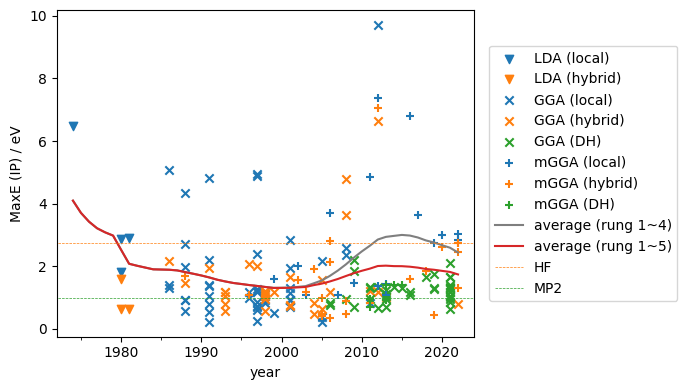

In [48]:
fig, ax = plt.subplots(figsize=(7, 4))

plt_x = tab_xc["year"]
plt_y = tab_etot.abs().T.max()
plt_year_x = list(range(1974, 2023))

plt_year_y = []
for year in range(1974, 2023):
    mask_year = (tab_xc["year"] > year - 5) & (tab_xc["year"] < year + 5)
    plt_year_y.append(plt_y[mask_year].mean())
plt_year_y_another = []
for year in range(len(plt_year_y)):
    plt_year_y_another.append(np.array(plt_year_y[max(0, year - 5):year + 5]).mean())
plt_year_y_another, plt_year_y = plt_year_y, plt_year_y_another

plt_year_y_low = []
for year in range(1974, 2023):
    mask_year = (tab_xc["year"] > year - 5) & (tab_xc["year"] < year + 5) & ~mask_hyb_corr
    plt_year_y_low.append(plt_y[mask_year].mean())
plt_year_y_another = []
for year in range(len(plt_year_y_low)):
    plt_year_y_another.append(np.array(plt_year_y_low[max(0, year - 5):year + 5]).mean())
plt_year_y_another, plt_year_y_low = plt_year_y_low, plt_year_y_another

ax.scatter(plt_x[mask_lda  & ~mask_hyb_ex], plt_y[mask_lda & ~mask_hyb_ex], marker="v", color="C0", label="LDA (local)" )
ax.scatter(plt_x[mask_lda  &  mask_hyb_ex], plt_y[mask_lda &  mask_hyb_ex], marker="v", color="C1", label="LDA (hybrid)")
ax.scatter(plt_x[mask_gga  & ~mask_hyb_ex & ~mask_hyb_corr], plt_y[mask_gga  & ~mask_hyb_ex & ~mask_hyb_corr], marker="x", color="C0", label="GGA (local)" )
ax.scatter(plt_x[mask_gga  &  mask_hyb_ex & ~mask_hyb_corr], plt_y[mask_gga  &  mask_hyb_ex & ~mask_hyb_corr], marker="x", color="C1", label="GGA (hybrid)")
ax.scatter(plt_x[mask_gga  &  mask_hyb_ex &  mask_hyb_corr], plt_y[mask_gga  &  mask_hyb_ex &  mask_hyb_corr], marker="x", color="C2", label="GGA (DH)"    )
ax.scatter(plt_x[mask_mgga & ~mask_hyb_ex & ~mask_hyb_corr], plt_y[mask_mgga & ~mask_hyb_ex & ~mask_hyb_corr], marker="+", color="C0", label="mGGA (local)" )
ax.scatter(plt_x[mask_mgga &  mask_hyb_ex & ~mask_hyb_corr], plt_y[mask_mgga &  mask_hyb_ex & ~mask_hyb_corr], marker="+", color="C1", label="mGGA (hybrid)")
ax.scatter(plt_x[mask_mgga &  mask_hyb_ex &  mask_hyb_corr], plt_y[mask_mgga &  mask_hyb_ex &  mask_hyb_corr], marker="+", color="C2", label="mGGA (DH)"    )

ax.plot(plt_year_x, plt_year_y_low, color="C7", label="average (rung 1~4)")
ax.plot(plt_year_x, plt_year_y, color="C3", label="average (rung 1~5)")
ax.plot([0, 10000], [2.729346050294114] * 2, color="C1", linewidth=0.5, linestyle="--", label="HF")
ax.plot([0, 10000], [0.977161164698367] * 2, color="C2", linewidth=0.5, linestyle="--", label="MP2")

ax.set_xlabel("year")
ax.set_ylabel("MaxE (IP) / eV")
ax.set_xticks(range(1975, 2025, 5), minor=True)
ax.set_xticks(range(1980, 2025, 10), minor=False)
ax.set_xlim(1972, 2024)
ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5))

fig.tight_layout()
fig.savefig("../MaxE-etot-against-year.pdf", transparent=True)

In [59]:
tab_etot.abs().T.mean()[~mask_hyb_ex].sort_values().iloc[:10]

functional
PBELYP       0.121795
mPWLYP1w     0.124598
PW91LYP      0.131271
TPSSLYP1w    0.152020
RPBE         0.257088
BLYP         0.273656
PBELYP1w     0.286872
PW91         0.293086
OLYP         0.320164
PW91PBE      0.391902
dtype: float64

In [58]:
tab_etot.abs().T.mean()[mask_hyb_ex & ~mask_hyb_corr].sort_values().iloc[:10]

functional
M06-2X      0.232841
M08-SO      0.245114
B3LYPV1R    0.248670
mPW1LYP     0.260684
M05         0.265551
X3LYP       0.273218
B3LYP*      0.314431
M05-2X      0.319363
O3LYP       0.341048
B97-K       0.345429
dtype: float64

In [61]:
tab_etot.abs().T.mean()[mask_hyb_corr].sort_values().iloc[:10]

functional
revXYG3          0.306523
lrc-XYG3         0.341842
XYG3             0.342296
xDH-PBE0         0.360880
mPW2PLYP         0.400164
PWPB95-D3Zero    0.439087
XYGJ-OS          0.467548
B2PLYP           0.471415
revXYGJ-OS       0.485586
XYG6             0.553565
dtype: float64

## Table of Errors

In [35]:
tab_xc.columns

Index(['year', 'type', 'hybrid ex', 'hybrid corr', 'XYG3-type'], dtype='object')

In [36]:
tab_err = tab_xc.copy()
tab_err.columns = pd.MultiIndex.from_tuples([("information", i) for i in tab_xc.columns])
for task in ["RHO", "GRD", "LR"]:
    tab_err[("density maxMNAE", task)] = tab_rdf[task].T.max()
for task in ["RHO", "GRD", "LR"]:
    tab_err[("density meanMNAE", task)] = tab_rdf[task].T.mean()
tab_err[("IP", "RMSE")] = (tab_etot.abs().T**2).mean()**0.5
tab_err[("IP", "MAE")] = tab_etot.abs().T.mean()
tab_err[("IP", "MaxE")] = tab_etot.abs().T.max()

In [38]:
tab_err.to_csv("Table-Summarized.csv")